<a href="https://colab.research.google.com/github/mahnoorbadar/Housing-data/blob/master/Artificial_Intelligence_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from glob import glob
from sklearn.preprocessing import StandardScaler # Used for scaling of data
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/sample_data/housing.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
housing_df = pd.read_csv('/content/sample_data/housing.csv')
housing_df = housing_df[:5000]
housing_df.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [ ]:
#descriptive statistics summary
housing_df['MEDV'].describe()

count    4.890000e+02
mean     4.543429e+05
std      1.653403e+05
min      1.050000e+05
25%      3.507000e+05
50%      4.389000e+05
75%      5.187000e+05
max      1.024800e+06
Name: MEDV, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


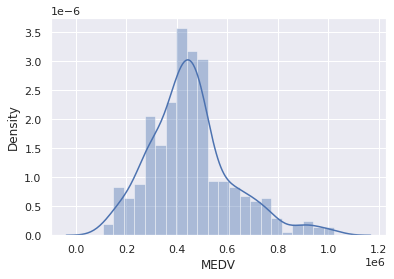

In [ ]:
#histogram
sns.distplot(housing_df['MEDV']);

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % housing_df['MEDV'].skew())
print("Kurtosis: %f" % housing_df['MEDV'].kurt())
# Skewness means the top of the iceberg is not in the middle but rather towards left or right.
# Kurtosis describe if the gaussian distrubution is very small and narrow or very wide

Skewness: 0.775082
Kurtosis: 1.041615


## Use a heatmap to see which features have strongest correlation with house price

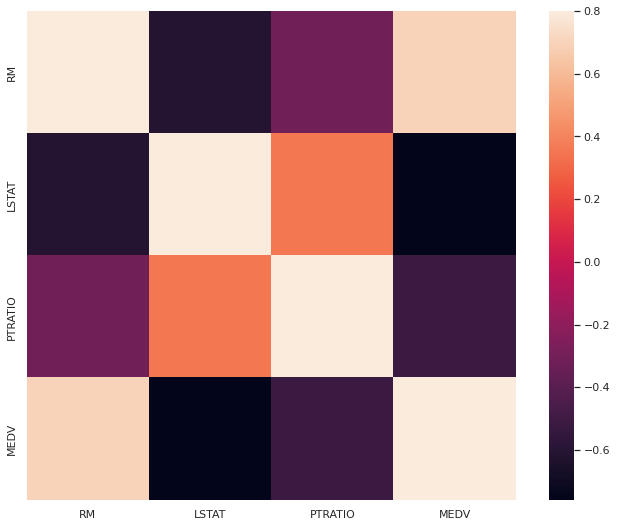

In [ ]:
#correlation matrix
corrmat = housing_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Here we can detect multicollinearity for example Residential Member (RM) and the Median Value of Owner (MEDV). So these hold more or less the same kind of data. The same goes for Percentage of lower status of the population (LSTAT), for example if you have a big house you also have more residential members in it.

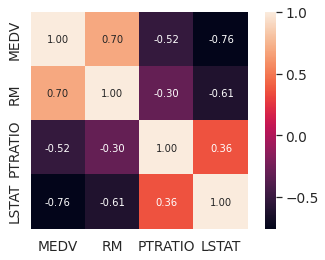

In [ ]:
# Median Value of Owner (MEDV) correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'MEDV')['MEDV'].index
cm = np.corrcoef(housing_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

As the value of LSTAT increases, the value of RM and MEDV decreases to a particular investor based on an individual investor's requirements and expectations.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


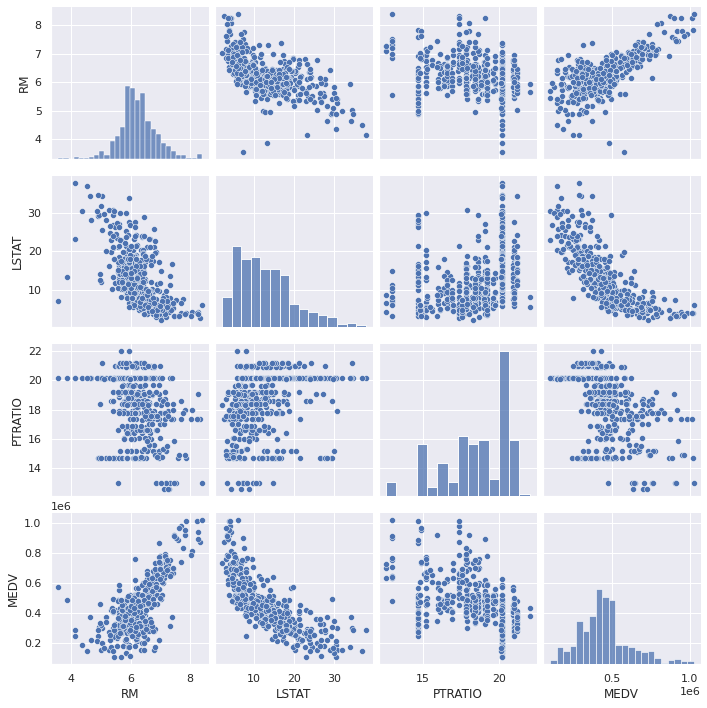

In [ ]:
# Scatterplot
sns.set()
cols = ['RM', 'LSTAT', 'PTRATIO', 'MEDV']
sns.pairplot(housing_df[cols], size = 2.5)
plt.show();

## The RM and MEDV seems to have similarities their MEDV plot looks almost identical.

In [ ]:
#standardizing data
MEDV_scaled = StandardScaler().fit_transform(housing_df['MEDV'][:,np.newaxis]);
low_range = MEDV_scaled[MEDV_scaled[:,0].argsort()][:10]
high_range= MEDV_scaled[MEDV_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-2.11503634]
 [-2.11503634]
 [-2.03875182]
 [-1.94975322]
 [-1.86075461]
 [-1.86075461]
 [-1.83532644]
 [-1.83532644]
 [-1.83532644]
 [-1.80989827]]

outer range (high) of the distribution:
[[2.77988684]
 [2.8180291 ]
 [2.84345727]
 [2.94516996]
 [3.02145448]
 [3.097739  ]
 [3.1867376 ]
 [3.39016298]
 [3.41559115]
 [3.45373341]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


## -Values that are similar to each other stay close to 0
## -Values that are a bit odd get high values such as the 3 values.

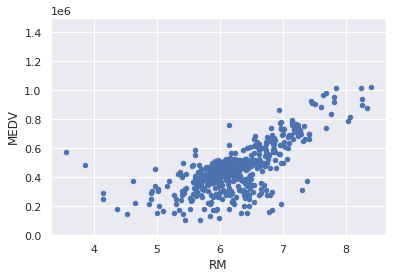

In [ ]:
#bivariate analysis saleprice/grlivarea
var = 'RM'
data = pd.concat([housing_df['MEDV'], housing_df[var]], axis=1)
data.plot.scatter(x=var, y='MEDV', ylim=(0,1500000));

## The two values with 0.4 -0.6 'MEDV' seem strange and they are not following the crowd. We can speculate why this is happening. These are the thus outliers.

In [ ]:
scale = StandardScaler()
X_train = housing_df[['RM', 'LSTAT', 'PTRATIO', 'MEDV']]
X_train = scale.fit_transform(X_train)
# Y is just the 'MEDV' column
y = housing_df['MEDV'].values
seed = 7
np.random.seed(seed)
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.33, random_state=seed)

In [ ]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                50        
                                                                 
 dense_9 (Dense)             (None, 30)                330       
                                                                 
 dense_10 (Dense)            (None, 40)                1240      
                                                                 
 dense_11 (Dense)            (None, 1)                 41        
                                                                 
Total params: 1,661
Trainable params: 1,661
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=150, batch_size=32)

Epoch 1/150
11/11 [==============================] - 1s 20ms/step - loss: 233182035968.0000 - mean_absolute_error: 452681.3438 - val_loss: 234771693568.0000 - val_mean_absolute_error: 457695.8125
Epoch 2/150
11/11 [==============================] - 0s 5ms/step - loss: 233181724672.0000 - mean_absolute_error: 452681.0000 - val_loss: 234771300352.0000 - val_mean_absolute_error: 457695.4688
Epoch 3/150
11/11 [==============================] - 0s 5ms/step - loss: 233181233152.0000 - mean_absolute_error: 452680.5625 - val_loss: 234770776064.0000 - val_mean_absolute_error: 457694.9062
Epoch 4/150
11/11 [==============================] - 0s 6ms/step - loss: 233180577792.0000 - mean_absolute_error: 452679.8750 - val_loss: 234769924096.0000 - val_mean_absolute_error: 457694.0625
Epoch 5/150
11/11 [==============================] - 0s 6ms/step - loss: 233179463680.0000 - mean_absolute_error: 452678.8438 - val_loss: 234768547840.0000 - val_mean_absolute_error: 457692.7500
Epoch 6/150
11/11 [=====

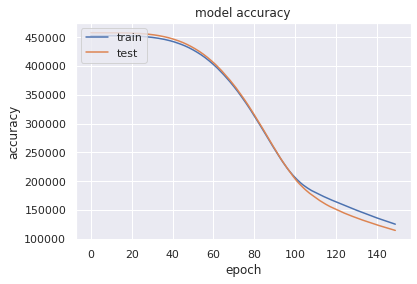

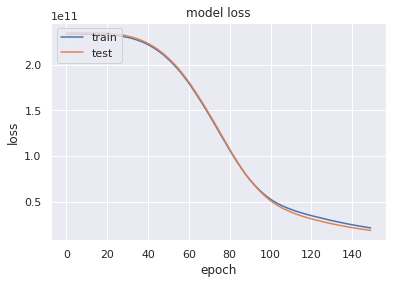

In [ ]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## This result is not very good and gives us a mean absolute error just above 140. I beleive this model performs bad due to the fact that we have a quite small data-set becuase a neural network performs the best when having a big dataset.

In [ ]:
prediction = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step
